In [0]:
#!pip install tensorflow==2

In [0]:
import keras.backend as K
import numpy as np
import tensorflow as tf

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

Using TensorFlow backend.


TensorFlow version: 2.0.0
Eager execution: True


In [0]:
@tf.custom_gradient
def O2RU(x):
    r=2
    g =  r*(r**2 * K.abs(x) + 1)**((1-r)/r)
    def grad(dy):
      return dy * g #dy = 1 
    return K.sign(x)*((r**2 * K.abs(x) + 1)**(1/r) - 1), grad

@tf.custom_gradient
def O3RU(x):
    r=3
    g =  r*(r**2 * K.abs(x) + 1)**((1-r)/r)
    def grad(dy):
      return dy * g #dy = 1 
    return K.sign(x)*((r**2 * K.abs(x) + 1)**(1/r) - 1), grad


# if you want to check diff in 0, automatic diff by TF gives 0 but it should be r
with tf.GradientTape() as g:
  x = tf.constant([0.0])
  g.watch(x)
  y = O3RU(x)
dy_dx = g.gradient(y, x)
print(dy_dx)

@tf.custom_gradient
def E2RU(x):
  r = 2
  gradient = tf.where(x >= 0, r*(r**2 * x + 1)**((1-r)/r), r*K.exp(r*x))
  def grad(dy):
      return dy * gradient
  return tf.where(x >= 0, (r**2 * x + 1)**(1/r) - 1/r, K.exp(r*x) - 1/r), grad

with tf.GradientTape() as g:
  x = tf.constant([-5.0,0.0,5.0,10.0,100.0])
  g.watch(x)
  y = E2RU(x)
dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor([3.], shape=(1,), dtype=float32)
tf.Tensor([9.0799862e-05 2.0000000e+00 4.3643579e-01 3.1234753e-01 9.9875234e-02], shape=(5,), dtype=float32)


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()
print(x_train.shape)
print(type(x_train))

57344/57026 [==============================] - 0s 0us/step
(404, 13)
<class 'numpy.ndarray'>


In [0]:
x_train[0:3,:]

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, 0.00000e+00, 5.38000e-01,
        6.14200e+00, 9.17000e+01, 3.97690e+00, 4.00000e+00, 3.07000e+02,
        2.10000e+01, 3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, 0.00000e+00, 4.15000e-01,
        7.61000e+00, 1.57000e+01, 6.27000e+00, 2.00000e+00, 3.48000e+02,
        1.47000e+01, 3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, 0.00000e+00, 6.31000e-01,
        4.97000e+00, 1.00000e+02, 1.33250e+00, 2.40000e+01, 6.66000e+02,
        2.02000e+01, 3.75520e+02, 3.26000e+00]])

In [0]:
y_train[0:3]

array([15.2, 42.3, 50. ])

In [0]:
from sklearn.preprocessing import StandardScaler

# here many people fits into scaler object whole dataset which can be misseading in terms of test error
scaler = StandardScaler()
scaler = scaler.fit(x_train)
x_train = scaler.transform(x_train).astype(np.float32)
x_test = scaler.transform(x_test).astype(np.float32)

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
features, labels = next(iter(train_dataset))

In [0]:
loss_object = tf.keras.losses.MeanAbsoluteError()

def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)
  return loss_object(y_true=y, y_pred=y_)

In [0]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [0]:
tf.compat.v1.set_random_seed(0)
model_bru = tf.keras.Sequential([
                                 tf.keras.layers.Dense(16, activation=O3RU),
                                 tf.keras.layers.Dense(16, activation=O2RU),
                                 tf.keras.layers.Dense(16, activation=O2RU),
                                 tf.keras.layers.Dense(16, activation=E2RU),

                                 #tf.keras.layers.Dense(16, activation=O2RU),
                                 #tf.keras.layers.Dense(16, activation=O2RU),
                                 #tf.keras.layers.Dense(16, activation=E2RU),
                                 #tf.keras.layers.Dense(16, activation=E2RU),
                                 tf.keras.layers.Dense(1)
])

model_relu = tf.keras.Sequential([
                                 tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                  
                                 #tf.keras.layers.Dense(16, activation='relu'),
                                 #tf.keras.layers.Dense(16, activation='relu'),
                                 #tf.keras.layers.Dense(16, activation='relu'),
                                 #tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(1)
])

model_elu = tf.keras.Sequential([
                                 tf.keras.layers.Dense(16, activation='elu'),
                                 tf.keras.layers.Dense(16, activation='elu'),
                                 tf.keras.layers.Dense(16, activation='elu'),
                                 tf.keras.layers.Dense(16, activation='elu'),

                                 #tf.keras.layers.Dense(16, activation='elu'),
                                 #tf.keras.layers.Dense(16, activation='elu'),
                                 #tf.keras.layers.Dense(16, activation='elu'),
                                 #tf.keras.layers.Dense(16, activation='elu'),
                                 tf.keras.layers.Dense(1)
])

model_leaky_relu = tf.keras.Sequential([
                                 tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),

                                 #tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 #tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 #tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 #tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Dense(1)
])

In [0]:
features, target = next(iter(train_dataset))
loss_value, grads = grad(model_bru, features, target)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),loss_value.numpy()))

Step: 0, Initial Loss: 21.570568084716797


In [0]:
import time

def train(model, data, num_epochs):
  train_loss_results = []

  epoch = 0
  for epoch in range(num_epochs):
    start = time.time()
    epoch_loss_avg = tf.keras.metrics.Mean()

    # Training loop - using batches of 64
    for x, y in data:
      # Optimize the model
      loss_value, grads = grad(model, x, y)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

      # Track progress
      epoch_loss_avg(loss_value)  # Add current batch loss
      

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    
    #if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    print ('Time taken for epoch {} sec\n'.format(time.time() - start))
    epoch +=1
  return train_loss_results

In [0]:
train_epoch = 25
l_bru = train(model_bru, train_dataset, train_epoch)

Epoch 000: Loss: 22.656
Time taken for epoch 0.07110333442687988 sec

Epoch 001: Loss: 21.605
Time taken for epoch 0.054110050201416016 sec

Epoch 002: Loss: 19.932
Time taken for epoch 0.05783677101135254 sec

Epoch 003: Loss: 17.845
Time taken for epoch 0.05207705497741699 sec

Epoch 004: Loss: 14.944
Time taken for epoch 0.05572199821472168 sec

Epoch 005: Loss: 10.351
Time taken for epoch 0.05135297775268555 sec

Epoch 006: Loss: 5.610
Time taken for epoch 0.05394792556762695 sec

Epoch 007: Loss: 4.893
Time taken for epoch 0.05121326446533203 sec

Epoch 008: Loss: 4.338
Time taken for epoch 0.061080217361450195 sec

Epoch 009: Loss: 4.257
Time taken for epoch 0.06926870346069336 sec

Epoch 010: Loss: 4.256
Time taken for epoch 0.06346940994262695 sec

Epoch 011: Loss: 4.024
Time taken for epoch 0.060530662536621094 sec

Epoch 012: Loss: 3.858
Time taken for epoch 0.05962228775024414 sec

Epoch 013: Loss: 3.994
Time taken for epoch 0.05210161209106445 sec

Epoch 014: Loss: 3.555
Ti

In [0]:
l_elu = train(model_elu, train_dataset, train_epoch)

Epoch 000: Loss: 22.346
Time taken for epoch 0.06017780303955078 sec

Epoch 001: Loss: 22.443
Time taken for epoch 0.04547691345214844 sec

Epoch 002: Loss: 22.053
Time taken for epoch 0.04353499412536621 sec

Epoch 003: Loss: 21.647
Time taken for epoch 0.04063773155212402 sec

Epoch 004: Loss: 21.010
Time taken for epoch 0.04123878479003906 sec

Epoch 005: Loss: 20.543
Time taken for epoch 0.044774770736694336 sec

Epoch 006: Loss: 20.185
Time taken for epoch 0.04578900337219238 sec

Epoch 007: Loss: 19.364
Time taken for epoch 0.04286694526672363 sec

Epoch 008: Loss: 17.803
Time taken for epoch 0.042694091796875 sec

Epoch 009: Loss: 14.354
Time taken for epoch 0.045265913009643555 sec

Epoch 010: Loss: 8.924
Time taken for epoch 0.045159339904785156 sec

Epoch 011: Loss: 7.176
Time taken for epoch 0.04854750633239746 sec

Epoch 012: Loss: 5.817
Time taken for epoch 0.051494598388671875 sec

Epoch 013: Loss: 4.458
Time taken for epoch 0.04259085655212402 sec

Epoch 014: Loss: 3.854

In [0]:
l_relu = train(model_relu, train_dataset, train_epoch)

Epoch 000: Loss: 22.345
Time taken for epoch 0.07698678970336914 sec

Epoch 001: Loss: 21.963
Time taken for epoch 0.05299115180969238 sec

Epoch 002: Loss: 21.706
Time taken for epoch 0.042687177658081055 sec

Epoch 003: Loss: 21.624
Time taken for epoch 0.04909014701843262 sec

Epoch 004: Loss: 21.441
Time taken for epoch 0.046875 sec

Epoch 005: Loss: 20.749
Time taken for epoch 0.04461789131164551 sec

Epoch 006: Loss: 19.863
Time taken for epoch 0.03901052474975586 sec

Epoch 007: Loss: 17.747
Time taken for epoch 0.040927886962890625 sec

Epoch 008: Loss: 14.005
Time taken for epoch 0.03906655311584473 sec

Epoch 009: Loss: 9.305
Time taken for epoch 0.04216456413269043 sec

Epoch 010: Loss: 7.714
Time taken for epoch 0.03619551658630371 sec

Epoch 011: Loss: 6.628
Time taken for epoch 0.039464473724365234 sec

Epoch 012: Loss: 5.334
Time taken for epoch 0.036786556243896484 sec

Epoch 013: Loss: 4.446
Time taken for epoch 0.036460161209106445 sec

Epoch 014: Loss: 3.589
Time tak

In [0]:
l_leaky_relu = train(model_leaky_relu, train_dataset, train_epoch)

Epoch 000: Loss: 23.041
Time taken for epoch 0.05440092086791992 sec

Epoch 001: Loss: 22.053
Time taken for epoch 0.04672718048095703 sec

Epoch 002: Loss: 22.279
Time taken for epoch 0.048135995864868164 sec

Epoch 003: Loss: 21.732
Time taken for epoch 0.04066205024719238 sec

Epoch 004: Loss: 21.790
Time taken for epoch 0.04032087326049805 sec

Epoch 005: Loss: 21.412
Time taken for epoch 0.040662527084350586 sec

Epoch 006: Loss: 21.781
Time taken for epoch 0.038301706314086914 sec

Epoch 007: Loss: 20.583
Time taken for epoch 0.03813052177429199 sec

Epoch 008: Loss: 20.153
Time taken for epoch 0.04639625549316406 sec

Epoch 009: Loss: 19.252
Time taken for epoch 0.040575504302978516 sec

Epoch 010: Loss: 17.624
Time taken for epoch 0.04030919075012207 sec

Epoch 011: Loss: 12.019
Time taken for epoch 0.038057565689086914 sec

Epoch 012: Loss: 6.448
Time taken for epoch 0.03823542594909668 sec

Epoch 013: Loss: 4.632
Time taken for epoch 0.03800654411315918 sec

Epoch 014: Loss: 

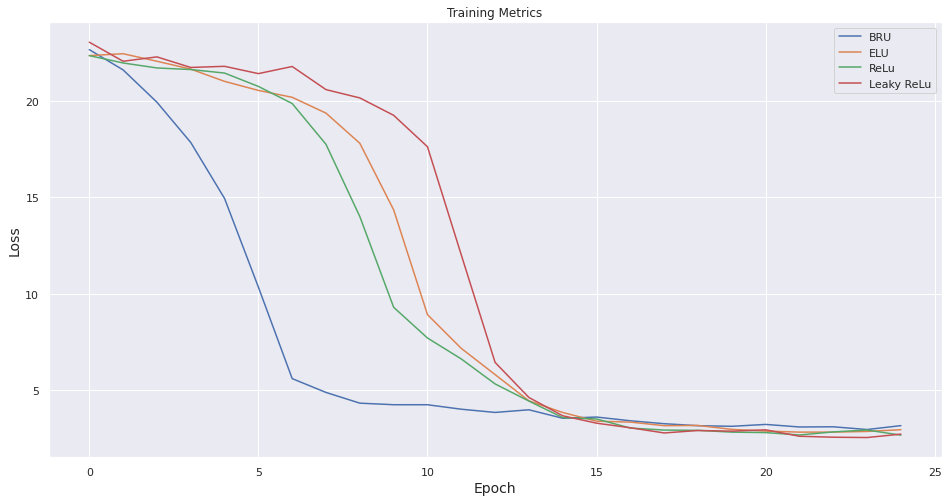

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(16, 8))
plt.title('Training Metrics')

plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.plot(l_bru, label='BRU')
plt.plot(l_elu, label='ELU')
plt.plot(l_relu, label='ReLu')
plt.plot(l_leaky_relu, label='Leaky ReLu')

plt.legend()
plt.show()

In [0]:
def eval(model, data):
  epoch_loss_avg = tf.keras.metrics.Mean()

  for x, y in data:
    loss_value, _ = grad(model, x, y)
    epoch_loss_avg(loss_value)
  
  return epoch_loss_avg.result()

In [0]:
l = eval(model_bru, test_dataset)
print("Loss: {:.3f}".format(l))

Loss: 3.531


In [0]:
l = eval(model_elu, test_dataset)
print("Loss: {:.3f}".format(l))

Loss: 4.453


In [0]:
l = eval(model_relu, test_dataset)
print("Loss: {:.3f}".format(l))

Loss: 3.405


In [0]:
l = eval(model_leaky_relu, test_dataset)
print("Loss: {:.3f}".format(l))

Loss: 3.276


In [0]:
tf.compat.v1.set_random_seed(0)
model_bru = tf.keras.Sequential([
                                 tf.keras.layers.Dense(16, activation=O3RU),
                                 tf.keras.layers.Dense(16, activation=O3RU),
                                 tf.keras.layers.Dense(16, activation=O3RU),
                                 tf.keras.layers.Dense(16, activation=O2RU),
                                 tf.keras.layers.Dense(16, activation=O2RU),
                                 tf.keras.layers.Dense(16, activation=O2RU),
                                 tf.keras.layers.Dense(16, activation=E2RU),
                                 tf.keras.layers.Dense(16, activation=E2RU),
                                 tf.keras.layers.Dense(1)
])

model_relu = tf.keras.Sequential([
                                 tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(1)
])

model_elu = tf.keras.Sequential([
                                 tf.keras.layers.Dense(16, activation='elu'),
                                 tf.keras.layers.Dense(16, activation='elu'),
                                 tf.keras.layers.Dense(16, activation='elu'),
                                 tf.keras.layers.Dense(16, activation='elu'),
                                 tf.keras.layers.Dense(16, activation='elu'),
                                 tf.keras.layers.Dense(16, activation='elu'),
                                 tf.keras.layers.Dense(16, activation='elu'),
                                 tf.keras.layers.Dense(16, activation='elu'),
                                 tf.keras.layers.Dense(1)
])

model_leaky_relu = tf.keras.Sequential([
                                 tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu),
                                 tf.keras.layers.Dense(1)
])

In [0]:
import time
def train_test(model, train_data, test_data, num_epochs):
  train_loss_results = []
  test_loss_results = []

  epoch = 0
  for epoch in range(num_epochs):
    start = time.time()
    epoch_loss_avg = tf.keras.metrics.Mean()
    test_loss_avg = tf.keras.metrics.Mean()

    # Training loop - using batches of 64
    for x, y in train_data:
      # Optimize the model
      loss_value, grads = grad(model, x, y)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      # Track progress
      epoch_loss_avg(loss_value)  # Add current batch loss
      
      for x_test, y_test in test_data:
        loss_test = loss(model, x_test, y_test, False)
        test_loss_avg(loss_test)

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    test_loss_results.append(test_loss_avg.result())
    #if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    print("Test Loss: {:.3f}".format(test_loss_avg.result()))
    print ('Time taken for epoch {} sec\n'.format(time.time() - start))
    epoch +=1
  return train_loss_results, test_loss_results

In [0]:
epoch = 200
t_loss_bru, test_loss_bru = train_test(model_bru, train_dataset, test_dataset, epoch)

Epoch 000: Loss: 20.642
Test Loss: 21.004
Time taken for epoch 0.36823487281799316 sec

Epoch 001: Loss: 16.221
Test Loss: 16.622
Time taken for epoch 0.31755900382995605 sec

Epoch 002: Loss: 10.378
Test Loss: 10.532
Time taken for epoch 0.3123288154602051 sec

Epoch 003: Loss: 6.384
Test Loss: 6.522
Time taken for epoch 0.3424243927001953 sec

Epoch 004: Loss: 5.590
Test Loss: 5.624
Time taken for epoch 0.3470008373260498 sec

Epoch 005: Loss: 5.068
Test Loss: 5.123
Time taken for epoch 0.34414029121398926 sec

Epoch 006: Loss: 4.864
Test Loss: 4.738
Time taken for epoch 0.3098719120025635 sec

Epoch 007: Loss: 4.658
Test Loss: 4.749
Time taken for epoch 0.32194972038269043 sec

Epoch 008: Loss: 4.658
Test Loss: 4.593
Time taken for epoch 0.31954002380371094 sec

Epoch 009: Loss: 4.172
Test Loss: 4.426
Time taken for epoch 0.3310997486114502 sec

Epoch 010: Loss: 4.273
Test Loss: 4.497
Time taken for epoch 0.3204638957977295 sec

Epoch 011: Loss: 4.053
Test Loss: 4.553
Time taken for

In [0]:
t_loss_elu, test_loss_elu = train_test(model_elu, train_dataset, test_dataset, epoch)

Epoch 000: Loss: 22.307
Test Loss: 22.724
Time taken for epoch 0.21648097038269043 sec

Epoch 001: Loss: 21.498
Test Loss: 22.205
Time taken for epoch 0.17458748817443848 sec

Epoch 002: Loss: 20.867
Test Loss: 21.554
Time taken for epoch 0.17313599586486816 sec

Epoch 003: Loss: 20.255
Test Loss: 20.596
Time taken for epoch 0.1680288314819336 sec

Epoch 004: Loss: 18.479
Test Loss: 18.937
Time taken for epoch 0.17657041549682617 sec

Epoch 005: Loss: 15.615
Test Loss: 15.589
Time taken for epoch 0.16750574111938477 sec

Epoch 006: Loss: 8.914
Test Loss: 9.045
Time taken for epoch 0.17009902000427246 sec

Epoch 007: Loss: 6.128
Test Loss: 6.606
Time taken for epoch 0.15906643867492676 sec

Epoch 008: Loss: 5.216
Test Loss: 5.762
Time taken for epoch 0.183884859085083 sec

Epoch 009: Loss: 4.878
Test Loss: 5.014
Time taken for epoch 0.16456222534179688 sec

Epoch 010: Loss: 4.372
Test Loss: 4.513
Time taken for epoch 0.1793820858001709 sec

Epoch 011: Loss: 4.236
Test Loss: 4.113
Time t

In [0]:
t_loss_relu, test_loss_relu = train_test(model_relu, train_dataset, test_dataset, epoch)

Epoch 000: Loss: 22.115
Test Loss: 23.064
Time taken for epoch 0.20939040184020996 sec

Epoch 001: Loss: 22.161
Test Loss: 22.921
Time taken for epoch 0.17895007133483887 sec

Epoch 002: Loss: 21.696
Test Loss: 22.764
Time taken for epoch 0.18339323997497559 sec

Epoch 003: Loss: 21.893
Test Loss: 22.597
Time taken for epoch 0.17004156112670898 sec

Epoch 004: Loss: 21.933
Test Loss: 22.412
Time taken for epoch 0.1577928066253662 sec

Epoch 005: Loss: 21.740
Test Loss: 22.196
Time taken for epoch 0.16593480110168457 sec

Epoch 006: Loss: 21.213
Test Loss: 21.929
Time taken for epoch 0.17307496070861816 sec

Epoch 007: Loss: 20.995
Test Loss: 21.578
Time taken for epoch 0.16225481033325195 sec

Epoch 008: Loss: 20.245
Test Loss: 21.058
Time taken for epoch 0.19351935386657715 sec

Epoch 009: Loss: 19.559
Test Loss: 20.140
Time taken for epoch 0.16819167137145996 sec

Epoch 010: Loss: 17.571
Test Loss: 17.695
Time taken for epoch 0.16111278533935547 sec

Epoch 011: Loss: 9.632
Test Loss:

In [0]:
t_loss_leaky_relu, test_loss_leaky_relu = train_test(model_leaky_relu, train_dataset, test_dataset, epoch)

Epoch 000: Loss: 22.569
Test Loss: 23.079
Time taken for epoch 0.20949769020080566 sec

Epoch 001: Loss: 21.964
Test Loss: 22.907
Time taken for epoch 0.1702892780303955 sec

Epoch 002: Loss: 22.307
Test Loss: 22.713
Time taken for epoch 0.17020320892333984 sec

Epoch 003: Loss: 21.840
Test Loss: 22.490
Time taken for epoch 0.16912555694580078 sec

Epoch 004: Loss: 21.406
Test Loss: 22.209
Time taken for epoch 0.16842007637023926 sec

Epoch 005: Loss: 21.788
Test Loss: 21.824
Time taken for epoch 0.16401124000549316 sec

Epoch 006: Loss: 20.941
Test Loss: 21.195
Time taken for epoch 0.1691751480102539 sec

Epoch 007: Loss: 19.488
Test Loss: 19.771
Time taken for epoch 0.16365933418273926 sec

Epoch 008: Loss: 14.825
Test Loss: 14.261
Time taken for epoch 0.17907452583312988 sec

Epoch 009: Loss: 7.617
Test Loss: 6.820
Time taken for epoch 0.16659808158874512 sec

Epoch 010: Loss: 4.649
Test Loss: 5.538
Time taken for epoch 0.16664433479309082 sec

Epoch 011: Loss: 6.639
Test Loss: 5.94

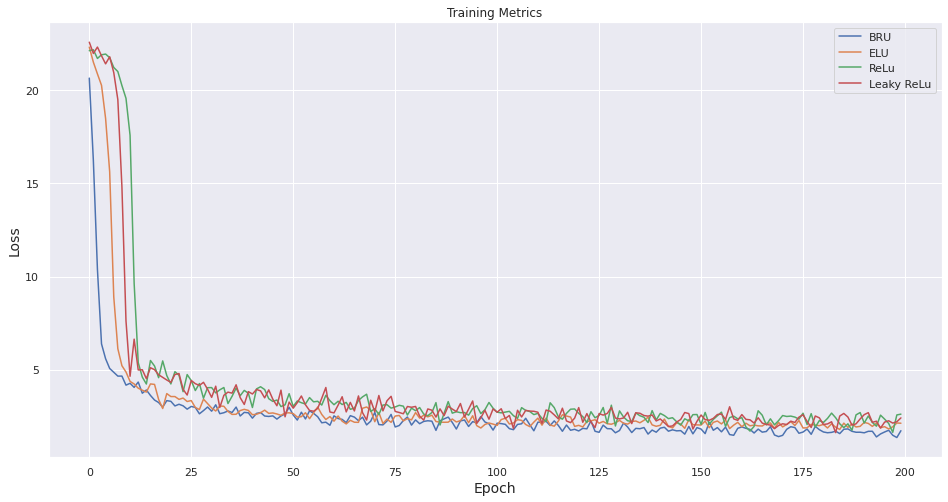

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(16, 8))
plt.title('Training Metrics')

plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.plot(t_loss_bru, label='BRU')
plt.plot(t_loss_elu, label='ELU')
plt.plot(t_loss_relu, label='ReLu')
plt.plot(t_loss_leaky_relu, label='Leaky ReLu')

plt.legend()
plt.show()

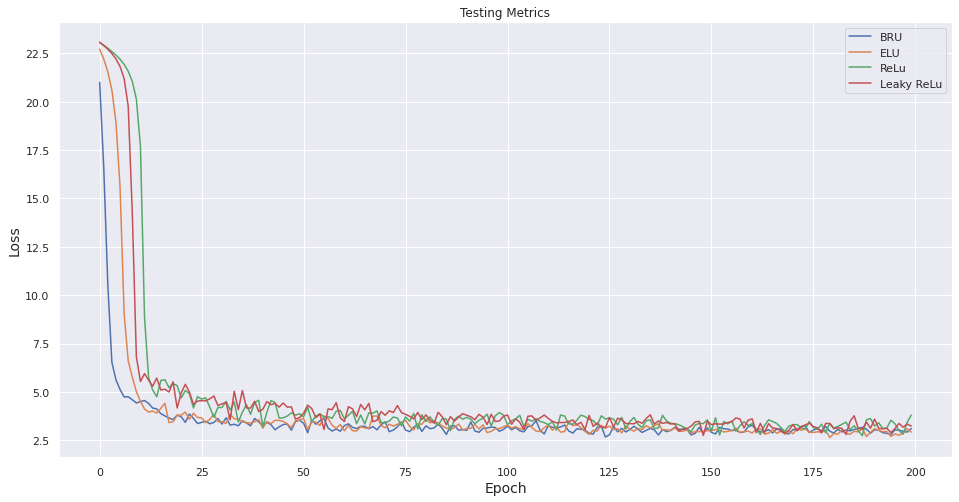

In [0]:
plt.figure(figsize=(16, 8))
plt.title('Testing Metrics')

plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.plot(test_loss_bru, label='BRU')
plt.plot(test_loss_elu, label='ELU')
plt.plot(test_loss_relu, label='ReLu')
plt.plot(test_loss_leaky_relu, label='Leaky ReLu')

plt.legend()
plt.show()